<a href="https://colab.research.google.com/github/chhaya-000/chhayaproject1/blob/main/project1_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports all the libraries used


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score,KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/dset1.csv"  # <- your file path
df = pd.read_csv(data_path) #loads the dataset from Drive into a pandas dataframe
print("Shape:", df.shape)
df.head(3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (700, 13)


,State/UT,District,Year,Population,GDP per Capita (INR),Literacy Rate (%),Poverty Rate (%),Unemployment Rate (%),Violent Crimes,Property Crimes,Cyber Crimes,Total Crimes Reported,"Crime Rate per 100,000"
0,Mizoram,Mizoram - District 4,2022,2163687,96490,75.9,18.3,6.6,787,9001,852,10640,491.75
1,Jharkhand,Jharkhand - District 4,2022,1381604,35454,91.2,19.3,7.2,3858,6404,578,10840,784.60
2,Rajasthan,Rajasthan - District 5,2019,302515,140494,73.4,30.7,7.8,4780,4509,737,10026,3314.22


In [ ]:
# Step 3: Standardize Column Names
# =======================
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(" ", "_")
              .str.replace(r"[()%/]", "", regex=True)  #regex is used to remove multiple special characters at once.
)
df.rename(columns={"stateut": "state/ut"}, inplace=True)
print("Cleaned Columns:", df.columns.tolist())

Cleaned Columns: ['state/ut', 'district', 'year', 'population', 'gdp_per_capita_inr', 'literacy_rate_', 'poverty_rate_', 'unemployment_rate_', 'violent_crimes', 'property_crimes', 'cyber_crimes', 'total_crimes_reported', 'crime_rate_per_100,000']


In [ ]:
# Step 4: Data Cleaning & Preprocessing

# Strip whitespace in text columns
for c in ["state/ut", "district"]:
    df[c] = df[c].astype(str).str.strip()

# Convert numeric columns safely
num_cols = df.select_dtypes(include=[np.number]).columns  #prints column names having numeric entries
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce") #replace invalid entries to NaN

# Handle missing values
df[num_cols] = df[num_cols].fillna(df[num_cols].median()) #fills missing entries by median


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state/ut                700 non-null    object 
 1   district                700 non-null    object 
 2   year                    700 non-null    int64  
 3   population              700 non-null    int64  
 4   gdp_per_capita_inr      700 non-null    int64  
 5   literacy_rate_          700 non-null    float64
 6   poverty_rate_           700 non-null    float64
 7   unemployment_rate_      700 non-null    float64
 8   violent_crimes          700 non-null    int64  
 9   property_crimes         700 non-null    int64  
 10  cyber_crimes            700 non-null    int64  
 11  total_crimes_reported   700 non-null    int64  
 12  crime_rate_per_100,000  700 non-null    float64
dtypes: float64(4), int64(7), object(2)
memory usage: 71.2+ KB
None

Descriptive Stat

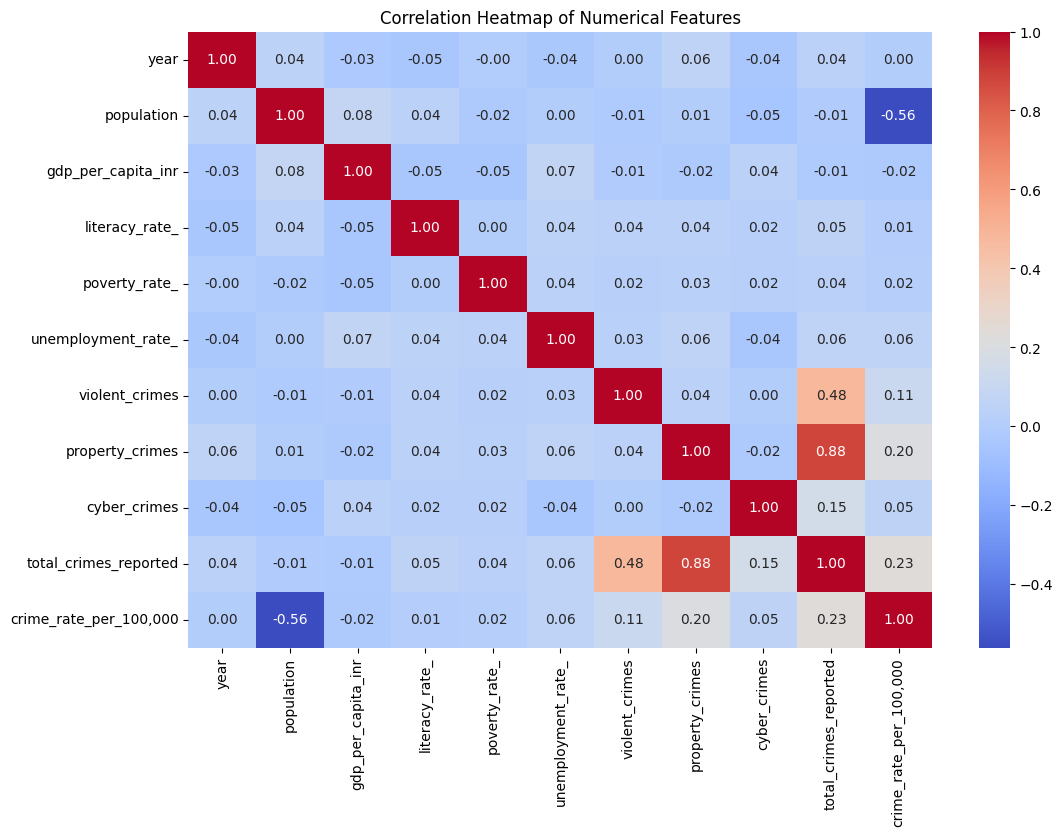

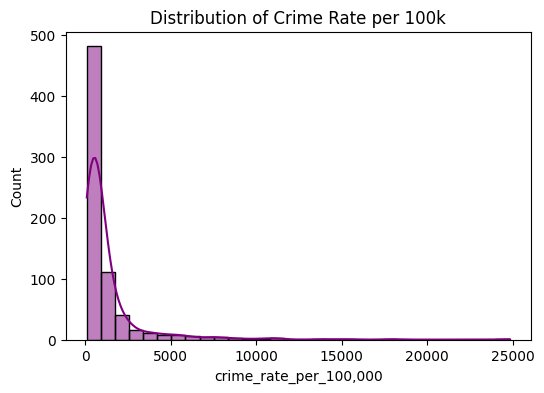

/tmp/ipython-input-1631791206.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, palette="magma")


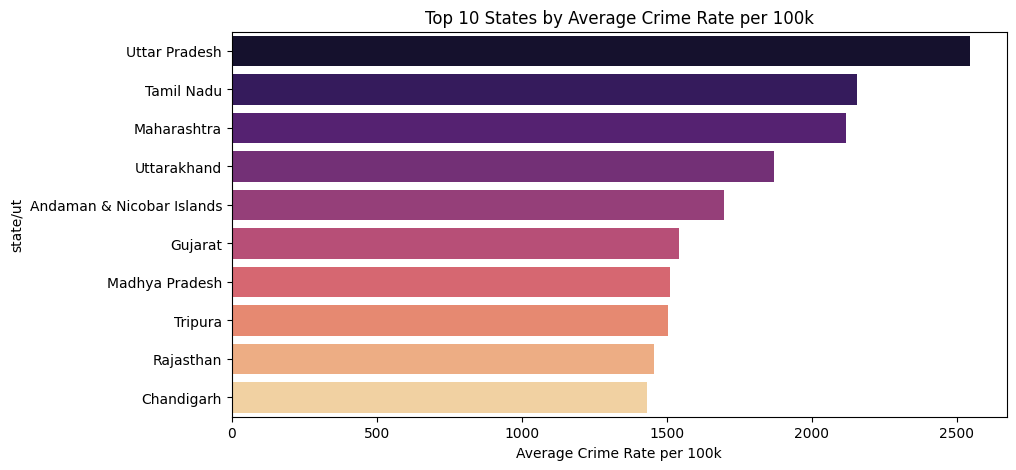

In [ ]:
# Step 5: Exploratory Data Analysis (EDA)
# =======================
print("\nDataset Info:")
print(df.info())
print("\nDescriptive Stats:")
print(df.describe())

# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Distribution of target variable
plt.figure(figsize=(6,4))
sns.histplot(df["crime_rate_per_100,000"], kde=True, bins=30, color="purple") #kde-adds a smooth curve on top of the histogram
plt.title("Distribution of Crime Rate per 100k")
plt.show()

# Top states by average crime rate
top_states = df.groupby("state/ut")["crime_rate_per_100,000"].mean().sort_values(ascending=False).head(10) #gives top 10 states with highest crime rates
plt.figure(figsize=(10,5))
sns.barplot(x=top_states.values, y=top_states.index, palette="magma")
plt.title("Top 10 States by Average Crime Rate per 100k")
plt.xlabel("Average Crime Rate per 100k")
plt.show()


In [ ]:
# Step 6: Feature Selection
# =======================
# Drop categorical text features for regression
X = df.drop(columns=["crime_rate_per_100,000", "state/ut", "district"])
y = df["crime_rate_per_100,000"]
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


For random forest model, RMSE is least and R2 metric is maximum so for our dataset, random forest is the best suit.

In [ ]:
# Step 7: Model Fitting
# =======================
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"RMSE": rmse, "R2": r2}
    print(f"{name}: RMSE = {rmse:.2f}, R2 = {r2:.3f}")

Linear Regression: RMSE = 1035.14, R2 = 0.376
Ridge Regression: RMSE = 1035.14, R2 = 0.376
Lasso Regression: RMSE = 1035.14, R2 = 0.376


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.359e+08, tolerance: 2.659e+05
  model = cd_fast.enet_coordinate_descent(


Random Forest: RMSE = 324.45, R2 = 0.939


In [ ]:
# Step 8: Cross-Validation (K-Fold)
# =======================
print("\nCross-Validation Results (5-Fold):")
cv_results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error"))

    cv_results[name] = {"CV_R2_Mean": r2_scores.mean(), "CV_RMSE_Mean": rmse_scores.mean()}
    print(f"{name}: CV R² = {r2_scores.mean():.3f}, CV RMSE = {rmse_scores.mean():.2f}")

cv_results_df = pd.DataFrame(cv_results).T
print("\nCross-Validation Performance:")
print(cv_results_df)



Cross-Validation Results (5-Fold):
Linear Regression: CV R² = 0.346, CV RMSE = 1582.71
Ridge Regression: CV R² = 0.346, CV RMSE = 1582.70


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.359e+08, tolerance: 2.659e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e+08, tolerance: 2.564e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e+08, tolerance: 2.050e

Lasso Regression: CV R² = 0.346, CV RMSE = 1582.71
Random Forest: CV R² = 0.920, CV RMSE = 559.80

Cross-Validation Performance:
                   CV_R2_Mean  CV_RMSE_Mean
Linear Regression    0.346175   1582.708622
Ridge Regression     0.346178   1582.704911
Lasso Regression     0.346175   1582.708104
Random Forest        0.919828    559.802180


/tmp/ipython-input-1375961054.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["R2"], palette="viridis")


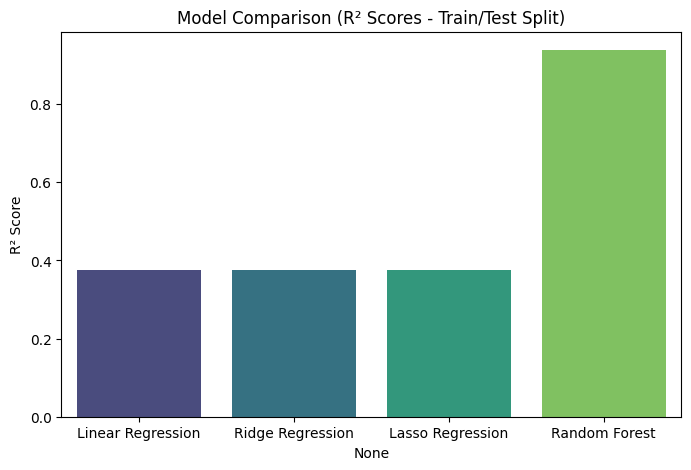

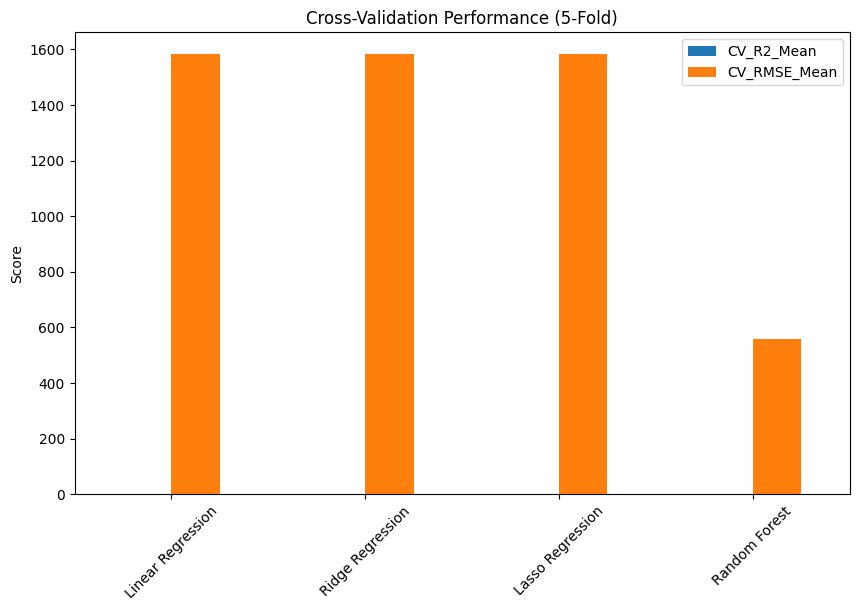

In [ ]:
# Step 9: Model Comparison (Visualization)
# =======================
results_df = pd.DataFrame(results).T
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["R2"], palette="viridis")
plt.title("Model Comparison (R² Scores - Train/Test Split)")
plt.ylabel("R² Score")
plt.show()

cv_results_df.plot(kind="bar", figsize=(10,6))
plt.title("Cross-Validation Performance (5-Fold)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-1054157547.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="cool")


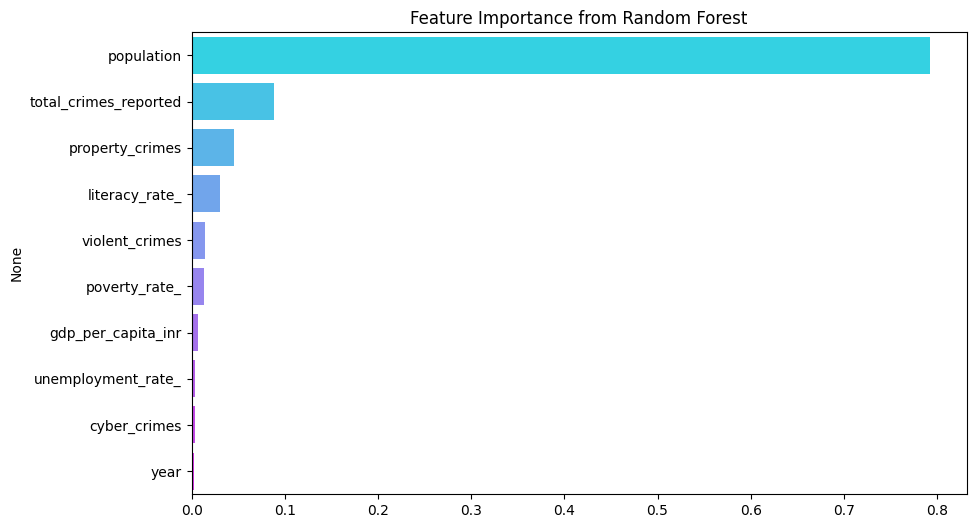

In [ ]:
# Step 10: Feature Importance (Random Forest)
# =======================
rf = models["Random Forest"]
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index, palette="cool")
plt.title("Feature Importance from Random Forest")
plt.show()